In [1]:
from autoreduce import *
import numpy as np
from sympy import symbols

In [3]:
# Post conservation law and other approximations phenomenological model at the RNA level
n = 4 # Number of states 
nouts = 2 # Number of outputs

# Inputs by user 
x_init = np.zeros(n)
n = 4 # Number of states 
timepoints_ode = np.linspace(0, 100, 100)
C = [[0, 0, 1, 0], [0, 0, 0, 1]]
nstates_tol = 3
error_tol = 0.3
# System dynamics symbolically

# params = [100, 50, 10, 5, 5, 0.02, 0.02, 0.01, 0.01]
# params = [1, 1, 5, 0.1, 0.2, 1, 1, 100, 100] # Parameter set for which reduction doesn't work
# K,b_t,b_l,d_t,d_l,del_t,del_l,beta_t,beta_l = params

x0 = symbols('x0')
x1 = symbols('x1')
x2 = symbols('x2')
x3 = symbols('x3')
x = [x0, x1, x2, x3]

K = symbols('K')
b_t = symbols('b_t')
b_l = symbols('b_l')
d_t = symbols('d_t')
d_l = symbols('d_l')
del_t = symbols('del_t')
del_l = symbols('del_l')
beta_t = symbols('beta_t')
beta_l = symbols('beta_l')
params = [K,b_t,b_l,d_t,d_l,del_t,del_l,beta_t,beta_l]
f0 = K * b_t**2/(b_t**2 + x[3]**2) - d_t * x[0]
f1 = K * b_l**2/(b_l**2 + x[2]**2) - d_l * x[1]
f2 = beta_t * x[0] - del_t * x[2]
f3 = beta_l * x[1] - del_l * x[3]
f = [f0,f1,f2,f3]
# parameter values
params_values = [100, 50, 10, 5, 5, 0.02, 0.02, 0.01, 0.01]
sys = System(x, f, params = params, params_values = params_values, C = C, x_init = x_init)

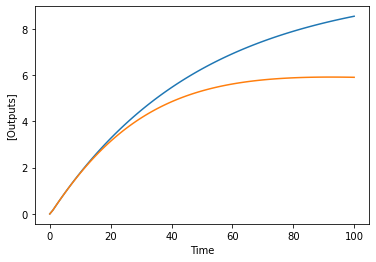

In [4]:
from autoreduce.utils import get_ODE
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
try:
    import matplotlib.pyplot as plt
    plt.plot(timepoints_ode, np.transpose(np.array(C)@sol))
    plt.xlabel('Time')
    plt.ylabel('[Outputs]')
    plt.show()
except:
    print('Plotting libraries missing.')

In [5]:
from autoreduce.utils import get_SSM
timepoints_ssm = np.linspace(0,100,100)
sys_ssm = get_SSM(sys, timepoints_ssm)
Ss = sys_ssm.compute_SSM() # len(timepoints) x len(params) x len(states)
out_Ss = []
for i in range(len(params)):
    out_Ss.append((np.array(C)@(Ss[:,i,:].T)))
out_Ss = np.reshape(np.array(out_Ss), (len(timepoints_ssm), len(params), nouts))

SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete


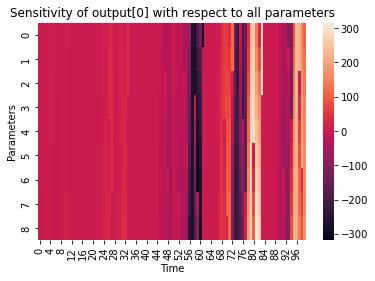

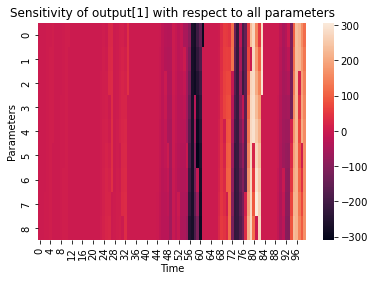

In [6]:
try:
    import seaborn as sn
    import matplotlib.pyplot as plt
    for j in range(nouts):
        sn.heatmap(out_Ss[:,:,j].T)
        plt.xlabel('Time')
        plt.ylabel('Parameters')
        plt.title('Sensitivity of output[{0}] with respect to all parameters'.format(j))
        plt.show()
except:
    print('Plotting libraries missing.')

In [7]:
from autoreduce.utils import get_reducible
timepoints_ssm = np.linspace(0,100,10)
timepoints_ode = np.linspace(0, 100, 100)
sys_reduce = get_reducible(sys, timepoints_ode, timepoints_ssm)
results = sys_reduce.reduce_simple()

Successful time-scale separation solution obtained with states: [x2, x3]!
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
Successful time-scale separation solution obtained with states: [x0, x2, x3]!
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
Successful time-scale separation solution obtained with states: [x1, x2, x3]!
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [8]:
list(results.keys())[0].f[1]

(K*b_l**2*beta_l - d_l*del_l*x3*(b_l**2 + x2**2))/(d_l*(b_l**2 + x2**2))

In [9]:
reduced_system, collapsed_system = sys_reduce.solve_timescale_separation([x0,x1], fast_states = [x3, x2])

Successful time-scale separation solution obtained with states: [x0, x1]!


In [10]:
reduced_system.f[1]

K*b_l**2/(b_l**2 + beta_t**2*x0**2/del_t**2) - d_l*x1